# Synthetic data, Hawkes processes

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr
import itertools

In [3]:
import os
import sys
import tqdm

In [4]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes/map511-p3a


In [5]:
for path in sys.path:
    print(path)

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload

/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


The standard Hawkes model has an underlying intensity given by
$$
    \lambda_t = \lambda^0_t + \int_0^t g(t-s)\,dN_s
$$
where the function $g \geq 0$ is called the _kernel_.

Here we simulate Hawkes processes with kernel $g(t) = \alpha\exp(-\delta t)$.

## Using `point-process-rust`

In [10]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [19]:
mu = 1.0
tmax = 60.0
alpha = 0.2
beta  = 5.
avg_num_of_events = tmax*mu/(1.-alpha/beta)
print("Expected avg evt no. %.3f" % avg_num_of_events)

Expected avg evt no. 62.500


In [139]:
n_traj = 1000
sample_trajectories = [
    ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha))
    for _ in range(n_traj)
]

20.3 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
print("Empirical average %.3f" % seq_lengths.to(torch.float).mean().item())

Number of samples: 		1000
Input size max. traj. length: 	89
tmax = 60.000
Empirical average 62.536


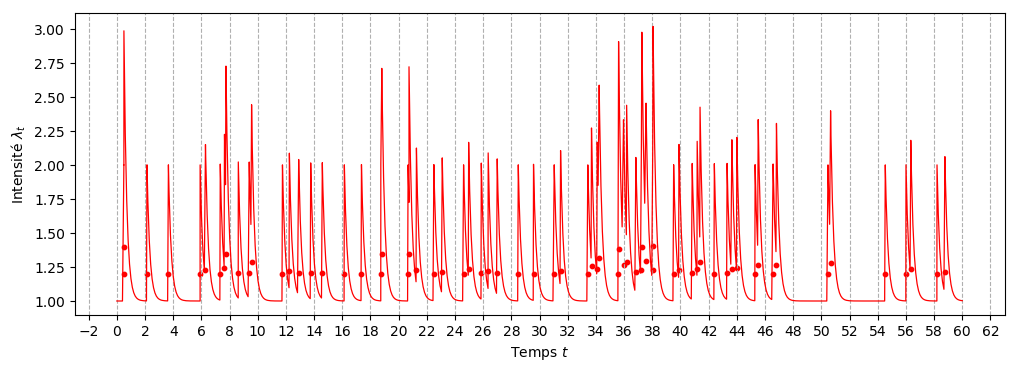

In [13]:
one_traj = sample_trajectories[1]
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,0]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

Text(0, 0.5, 'Number')

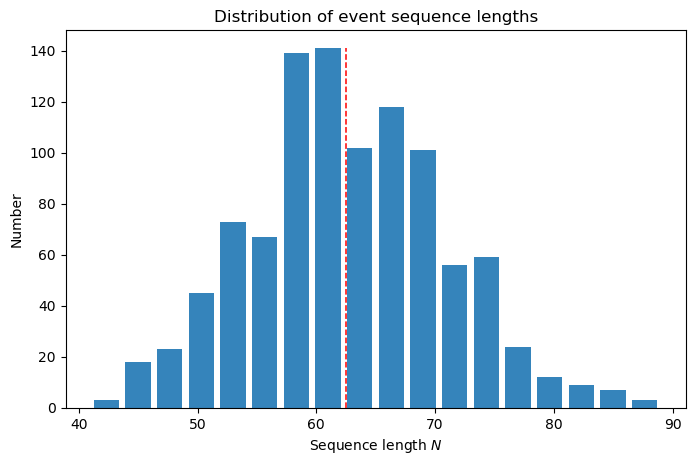

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
arr, bins, patches = ax.hist(seq_lengths,
                             bins=2*int(seq_lengths.size(0)**(1/3)),
                             rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.vlines(avg_num_of_events, 0., arr.max(),
          linestyles="--", linewidth=1.1, color="r")
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

## Save the tensor down to a file

In [15]:
import pickle
filepath = "../data/simulated/hawkes_sim_tensor_save.pkl"
with open(filepath, "wb") as f:
    save_data_ = {
        "mu": mu,
        "alpha": alpha,
        "decay": beta,
        "tmax": tmax,
        "lengths": seq_lengths
    }
    pickle.dump(save_data_, f)

# Tick

In [15]:
import tick
import tick.hawkes
from tick.plot import plot_point_process

In [17]:
def fuse_node_times(e):
    """
    Given timestamps from a simulated process, fuse timestamps
    from both nodes, with the tagged event types.
    """
    n_nodes = len(e)
    type_list = [
        i*np.ones_like(e[i], dtype=int) for i in range(n_nodes)
    ]
    concat_times = np.concatenate(e)
    sorting_indices = concat_times.argsort()
    type_arr = np.concatenate(type_list)[sorting_indices]
    return concat_times[sorting_indices], type_arr

## 1D

$$
    g(t) = \alpha\beta\exp(-\beta t)
$$

In [74]:
mu = 1.0
tmax = 60.0
alpha = 0.5
beta  = 3.

In [75]:
hawkes = tick.hawkes.SimuHawkesExpKernels(
    [[alpha]],
    [[beta]],
    baseline=[mu],
    end_time=tmax,
    verbose=False
)

In [76]:
tmax/(1-hawkes.spectral_radius())

120.0

In [77]:
hawkes.reset()
hawkes.track_intensity(0.01)
hawkes.simulate()

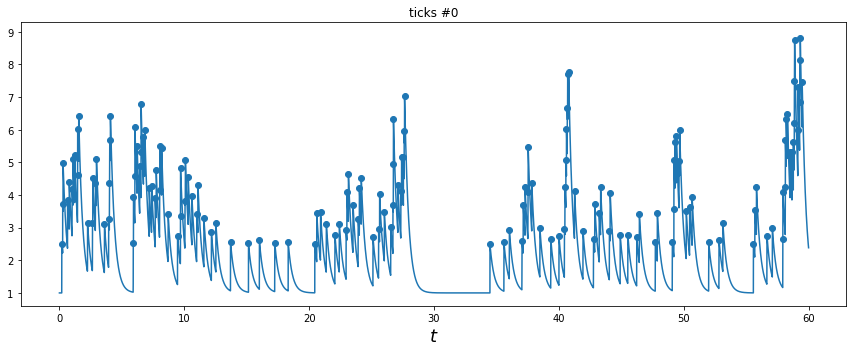

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
_ = plot_point_process(hawkes, ax=ax)
fig.tight_layout()

In [79]:
n_simulations = 2000

In [82]:
hawkes.reset()

multi = tick.hawkes.SimuHawkesMulti(hawkes, n_simulations=n_simulations,
                                    n_threads=2)

In [83]:
multi.simulate()

In [85]:
import datetime
now = datetime.datetime.now()

date_format = "%Y%m%d-%H%M%S"
file_timestamp = now.strftime(date_format)
file_timestamp

filepath = os.path.join('..', 'data', 'simulated', 'hawkes_synthetic_exp_1d_{}.pkl'
                        .format(file_timestamp))
print(filepath)

../data/simulated/hawkes_synthetic_exp_1d_20181201-205742.pkl


In [94]:
tagged_timestamps = [
    fuse_node_times(e) for e in multi.timestamps
]

event_timestamps, event_types = list(zip(*tagged_timestamps))

import pickle
if os.path.exists(filepath):
    print("Warning! File already exists")
    confirm = input("Confirm ? [y/N]")
    if confirm in ["y", "Y", "yes"]:
        with open(filepath, "wb") as f:
            save_data_ = {
                "mu": mu,
                "alpha": alpha,
                "decay": beta,
                "tmax": tmax,
                "timestamps": event_timestamps,
                "types": event_types,
                "lengths": multi.n_total_jumps
            }

            pickle.dump(save_data_, f)
        print("Overwritten.")
    else:
        print("Operation canceled.")
    

Warning! File already exists


Confirm ? [y/N] y


Overwritten.


## 2D Hawkes process

In [12]:
seed = 653

In [13]:
tmax = 120

In [14]:
adjacency_2d = np.array([
    [0.1, 0.15],
    [0.01, 0.01]
])
decay_2d = 1.2
baseline_2d = np.array([0.7*mu, mu])

In [11]:
hawkes_2d = tick.hawkes.SimuHawkesExpKernels(
    adjacency_2d,
    decay_2d,
    baseline=baseline_2d,
    end_time=tmax,
    verbose=False
)

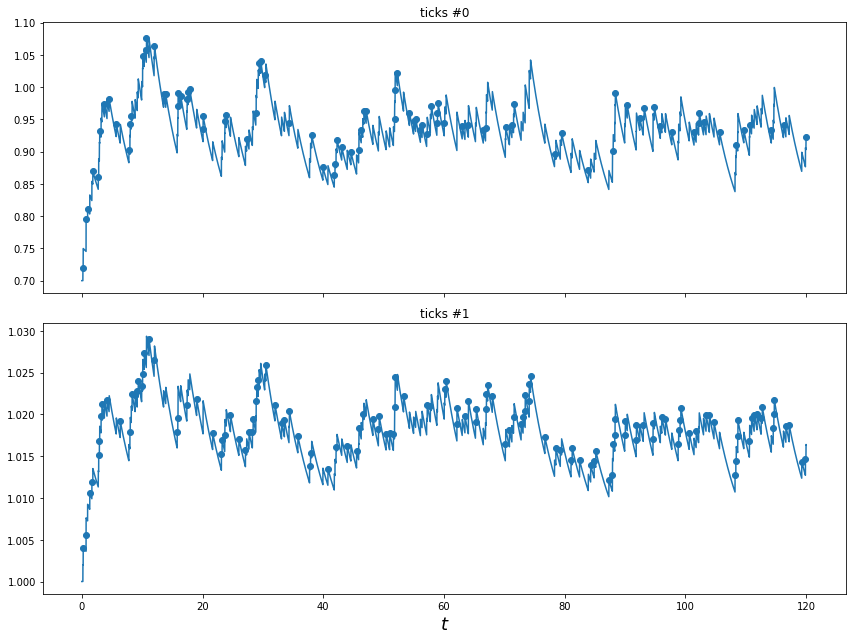

In [12]:
hawkes_2d.reset()
hawkes_2d.track_intensity(0.01)
hawkes_2d.simulate()

fig, ax = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
_ = plot_point_process(hawkes_2d, ax=ax)
fig.tight_layout()

In [13]:
hawkes_2d.reset()
multi_2d = tick.hawkes.SimuHawkesMulti(hawkes_2d, n_simulations=600,
                                       n_threads=4)

In [14]:
multi_2d.simulate()

In [16]:
tagged_timestamps = [
    fuse_node_times(e) for e in multi_2d.timestamps
]

event_timestamps, event_types = list(zip(*tagged_timestamps))

In [17]:
import datetime

In [18]:
now = datetime.datetime.now()

date_format = "%Y%m%d-%H%M%S"
file_timestamp = now.strftime(date_format)
file_timestamp

filepath = os.path.join('..', 'data', 'simulated', 'hawkes_synthetic_exp_2d_{}.pkl'.format(file_timestamp))
print(filepath)

../data/simulated/hawkes_synthetic_exp_2d_20181201-002801.pkl


In [19]:
import pickle
with open(filepath, "wb") as f:
    save_data_ = {
        "mu": baseline_2d,
        "alpha": adjacency_2d,
        "decay": decay_2d,
        "tmax": tmax,
        "timestamps": event_timestamps,
        "types": event_types,
        "lengths": multi_2d.n_total_jumps
    }
    if os.path.exists(filepath):
        print("Warning! File already exists")
        confirm = input("Confirm ? [y/N]")
        if confirm in ["y", "Y", "yes"]:
            pickle.dump(save_data_, f)
            print("Overwritten.")
        else:
            print("Operation canceled.")
    else:
        pickle.dump(save_data_, f)

Warning! File already exists


Confirm ? [y/N] y


Overwritten.
